In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline


AP_hierDF = pd.read_excel('/home/penglab/FeaCal/dataSource/axonProj/AP_hierDF.xlsx', index_col=0)
AP_kmeansDF = pd.read_excel('/home/penglab/FeaCal/dataSource/axonProj/AP_kmeansDF.xlsx', index_col=0)
AP_dbscanDF = pd.read_excel('/home/penglab/FeaCal/dataSource/axonProj/AP_dbscanDF.xlsx', index_col=0)
AP_hdbscanDF = pd.read_excel('/home/penglab/FeaCal/dataSource/axonProj/AP_hdbscanDF.xlsx', index_col=0)
AP_snnDF = pd.read_excel('/home/penglab/FeaCal/dataSource/axonProj/AP_snnDF.xlsx', index_col=0)

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 1.10
Loading CCF brain structure data...
Loading time: 0.01
Loading...
number of files under swc_path: 1002
100 loaded: 6.1s
Invalid number of soma found: 0
QC failed: AA0114.swc
Invalid number of soma found: 0
QC failed: AA0115.swc
200 loaded: 4.5s
300 loaded: 5.1s
400 loaded: 5.4s
Invalid number of soma found: 0
QC failed: AA0472.swc
500 loaded: 5.5s
Invalid number of soma found: 0
QC failed: AA0576.swc
Invalid number of soma found: 0
QC failed: AA0585.swc
Invalid number of soma found: 0
QC failed: AA0589.swc
600 loaded: 5.9s
Invalid number of soma found: 0
QC failed: AA0639.swc
Invalid number of soma found: 0
QC failed: AA0670.swc
Invalid number of soma found: 0
QC failed: AA0672.swc
700 loaded: 5.0s
Invalid number of soma found: 0
QC failed: AA0754.swc
Invalid number of soma found: 0
QC failed: AA0763.swc
800 loaded: 5.9s
900 loaded: 4.6s
QC failed: AA0952.swc
QC failed

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/neuron_features.py:337: RuntimeWarning:

divide by zero encountered in true_divide

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/neuron_features.py:337: RuntimeWarning:

invalid value encountered in true_divide



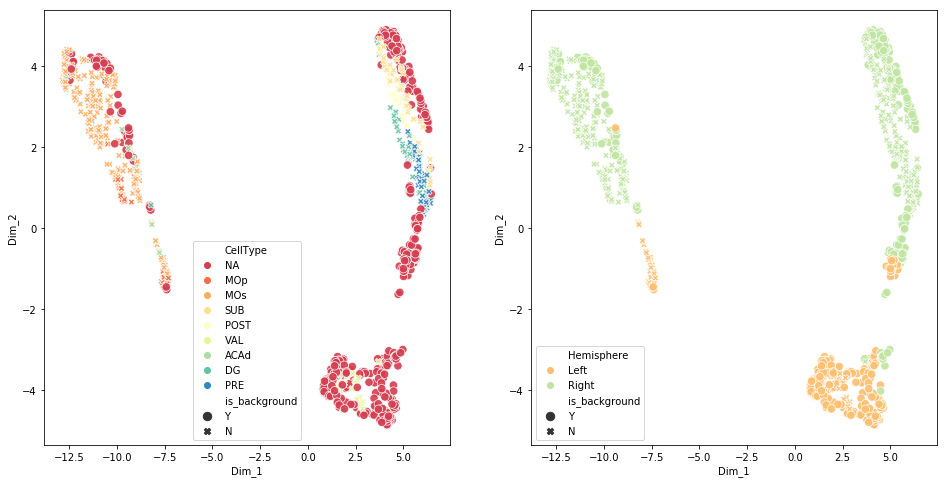

In [2]:

import neuro_morpho_toolbox as nmt
ns = nmt.neuron_set('/home/penglab/Documents/Janelia_1000')
_ = ns.ReduceDimUMAP(feature_set="soma_features", n_neighbors=100)
_ = ns.FeatureScatter(["CellType", "Hemisphere"], map="UMAP")


## Set Color

In [3]:
import seaborn as sns; sns.set()




colorlist=["#7FC97F","#BEAED4","#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D","#666666","#A6CEE3","#1F78B4","#B2DF8A","#33A02C",
           "#FB9A99","#E31A1C","#FDBF6F","#FF7F00","#CAB2D6","#6A3D9A","#FFFF99","#B15928","#FBB4AE","#B3CDE3",
           "#CCEBC5","#DECBE4","#FED9A6","#FFFFCC","#E5D8BD","#FDDAEC","#F2F2F2","#B3E2CD","#FDCDAC","#CBD5E8",
           "#F4CAE4","#E6F5C9","#FFF2AE","#F1E2CC","#CCCCCC","#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00",
           "#FFFF33","#A65628","#F781BF","#999999","#66C2A5","#FC8D62","#8DA0CB","#E78AC3","#A6D854","#FFD92F",
           "#E5C494","#B3B3B3","#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5",
           "#D9D9D9","#BC80BD","#CCEBC5"]
lut = dict(zip(ns.metadata['CellType'].unique(), colorlist))
row_colors = ns.metadata['CellType'].map(lut)
row_colors[row_colors.isnull()]='white'

# Plot cocluster 

In [75]:

from scipy.spatial import distance
from scipy.cluster import hierarchy
import numpy as np

#print the cocluster result
#output the linkage matrix
def bestCOCLUSTER(df):
    linkmethod = ['single', 'complete','average','weighted','centroid','median','ward']
    paraDF = pd.DataFrame(columns =['method','CCC'],index = linkmethod)
    paraDF.loc[:,'method'] = linkmethod
    
    for iter_m in linkmethod:
        Y = distance.pdist(np.asarray(df))
        Z = hierarchy.linkage(Y, method = iter_m)
        c, coph_dists = hierarchy.cophenet(Z,Y)
        paraDF.loc[iter_m,'CCC'] = c
    paraDF.sort_values(by='CCC', ascending = False, inplace = True)
    #print(paraDF)
    row_linkage = hierarchy.linkage(distance.pdist(np.asarray(df)), method = paraDF.iloc[0,0])

    col_linkage = hierarchy.linkage(distance.pdist(np.asarray(df).T), method = paraDF.iloc[0,0])
    #print(paraDF.iloc[0,0])
    sns.clustermap(df, row_linkage = row_linkage, col_linkage = col_linkage, row_colors=row_colors ,col_colors = row_colors, figsize=(13, 13))#, cmap=sns.diverging_palette(h_neg=150, h_pos=275, s=80, l=55, as_cmap=True))    
    return hierarchy.linkage(distance.pdist(np.asarray(df)))



def coclusterResult(Z_sample):
    t = input('Please input the number of cluster: ')
    return fcluster(Z_sample,t,criterion='maxclust')

## Set neuron_set.metadata['Cluster']

From featureDF we can generate the corresponding UMAP, then we will use the coclustering result to perfrom fcluster, then set the ['cluster']result

In [76]:
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    return list(duplicateColumnNames)

* featureDF is the dataframe containing features extracted from Vaa3D
* Z_Sample is the condensed distance matrix from cocluster

In [129]:
import pickle
def generateNS(featureDF,ns_input,coclusterDF, storePath,step):
    index_origin = ns_input.metadata.index.tolist()
    ns_input.UMAP = nmt.UMAP_wrapper(featureDF, n_neighbors=100, min_dist=0.1, n_components=2, metric='euclidean',
                               PCA_first=True,n_PC=100)
    print('Shape of the UMAP is '+ str(ns_input.UMAP.shape))

    index_after = ns_input.UMAP.index.tolist()
    index_update = [i for i in index_origin if i in index_after ]
    ns_input.metadata = ns_input.metadata.loc[index_update,:]
    ns_input.UMAP = ns_input.UMAP .loc[index_update,:]
    # The cocluster shown only includes the intersection of featureset and best cocluster
    Z_sample = bestCOCLUSTER(coclusterDF.loc[index_update,:])
    if step==2:
        cur_clusters = coclusterResult(Z_sample)
        ns_input.metadata['Cluster'] = ['C' + str(i) for i in cur_clusters]  
        pickle.dump([ns_input], open(storePath+'ns_output.pickle', "wb"))

#### For axon morphology features

Shape of the UMAP is (720, 2)


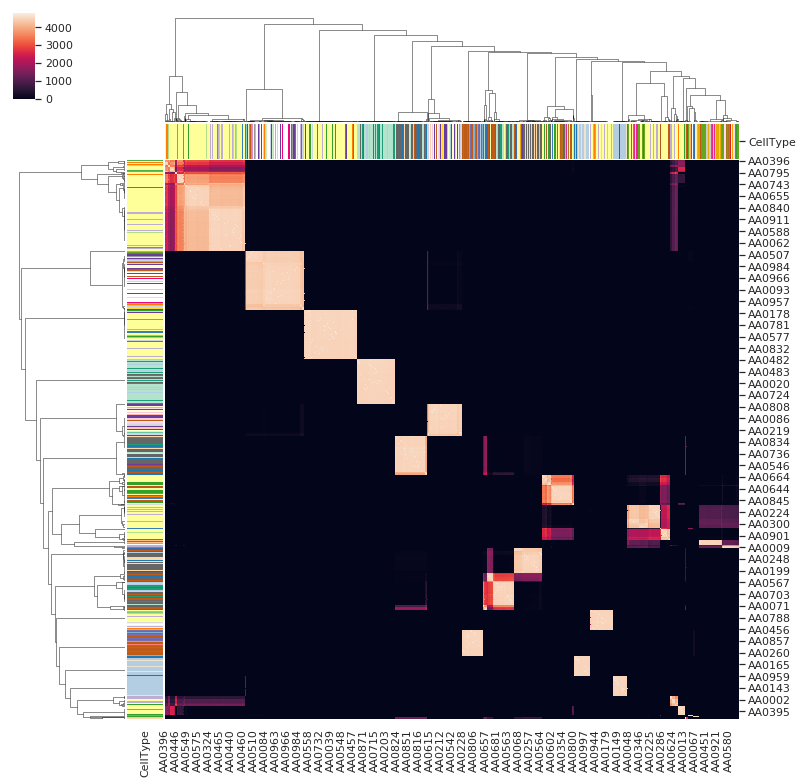

In [128]:
generateNS(lm_axon_df_scale,ns,AP_hierDF,'/home/penglab/FeaCal/Jmorpho_features/',1)

Please input the number of cluster: 18


AA0001     C7
AA0002    C18
AA0003    C18
AA0004    C11
AA0005    C18
AA0006    C13
AA0007     C7
AA0008     C7
AA0009    C11
AA0010    C13
AA0011     C5
AA0012     C5
AA0013    C16
AA0014    C14
AA0015     C9
AA0016     C9
AA0017     C4
AA0019     C9
AA0020     C2
AA0021     C2
AA0022    C15
AA0024     C2
AA0025     C9
AA0026     C2
AA0027     C6
AA0028     C6
AA0030     C2
AA0031    C15
AA0032     C2
AA0033     C2
         ... 
AA0966     C4
AA0967     C4
AA0969     C4
AA0970     C4
AA0971     C4
AA0972     C4
AA0973     C4
AA0974     C4
AA0975     C4
AA0976     C4
AA0978     C4
AA0979     C4
AA0980     C4
AA0981     C4
AA0982     C4
AA0983     C4
AA0984     C4
AA0985     C4
AA0986     C4
AA0987     C3
AA0988     C4
AA0990     C4
AA0991     C4
AA0993     C4
AA0994     C7
AA0995     C4
AA0997     C8
AA0998    C10
AA0999     C8
AA1000     C7
Name: Cluster, Length: 716, dtype: object

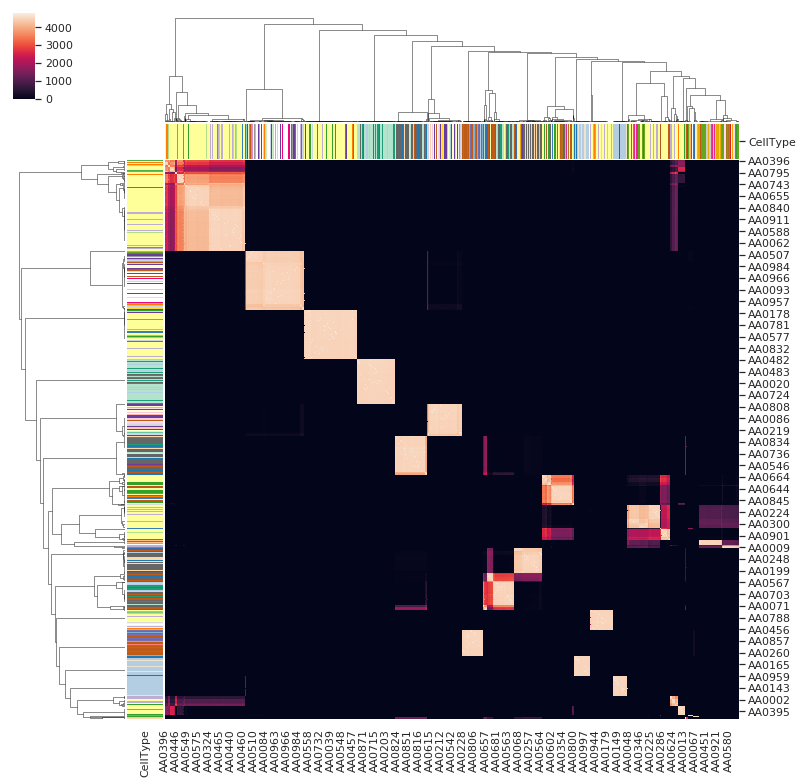

In [125]:
ns.metadata = ns.metadata.loc[index_update,:]
ns.UMAP = ns.UMAP .loc[index_update,:]
Ztemp = bestCOCLUSTER(AP_hierDF.loc[index_update,:])
Z_sample = Ztemp.copy()
cur_clusters = coclusterResult(Z_sample)
ns.metadata['Cluster'] = ['C' + str(i) for i in cur_clusters]  
ns.metadata['Cluster'] 

In [123]:
AP_hierDF.index

Index(['AA0001', 'AA0002', 'AA0003', 'AA0004', 'AA0005', 'AA0006', 'AA0007',
       'AA0008', 'AA0009', 'AA0010',
       ...
       'AA0993', 'AA0994', 'AA0995', 'AA0996', 'AA0997', 'AA0998', 'AA0999',
       'AA1000', 'AA1001', 'AA1002'],
      dtype='object', length=987)

In [121]:
ns.UMAP.shape

(716, 2)

In [120]:
ns.metadata.shape

(716, 4)

In [122]:
    featureDF = lm_axon_df_scale.copy()
    Z_sample = Ztemp.copy()
    ns_input = ns
    index_origin = ns_input.metadata.index.tolist()
    ns_input.UMAP = nmt.UMAP_wrapper(featureDF, n_neighbors=100, min_dist=0.1, n_components=2, metric='euclidean',
                               PCA_first=True,n_PC=100)
    index_after = ns_input.UMAP.index.tolist()
    index_update = [i for i in index_origin if i in index_after ]
    ns_input.metadata = ns_input.metadata.loc[index_update,:]
    ns_input.UMAP = ns_input.UMAP .loc[index_update,:]

    cur_clusters = coclusterResult(Z_sample)
    ns_input.metadata['Cluster'] = ['C' + str(i) for i in cur_clusters]  
    pickle.dump([ns_input], open(storePath+'ns_output.pickle', "wb"))

Please input the number of cluster: 1


ValueError: Length of values does not match length of index

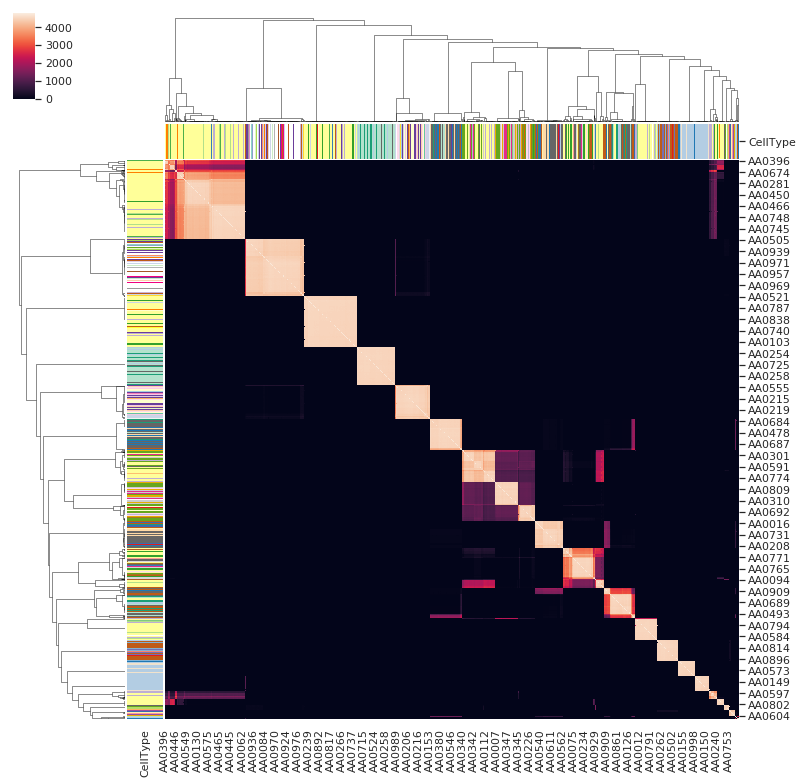

In [109]:
generateNS(lm_axon_df_scale,ns,Ztemp,'/home/penglab/FeaCal/Jmorpho_features/')

Please input the number of cluster: 18


ValueError: Length of values does not match length of index

#### For dendrite morphology features

In [ ]:
lm_dendrite_df_scale = pd.read_excel('/home/penglab/FeaCal/Jmorpho_features/lm_dendrite_df_scale.xlsx' index_col=0)

# Cocluster for axon projection

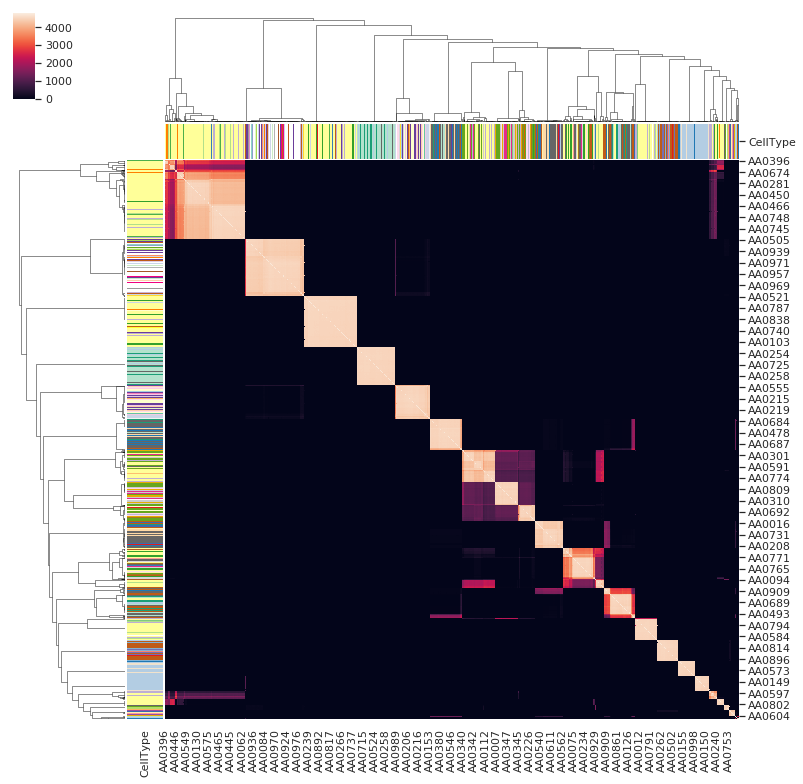

In [67]:
Ztemp = bestCOCLUSTER(AP_hierDF)


In [70]:
coclusterResult(Ztemp)

Please input the number of cluster18


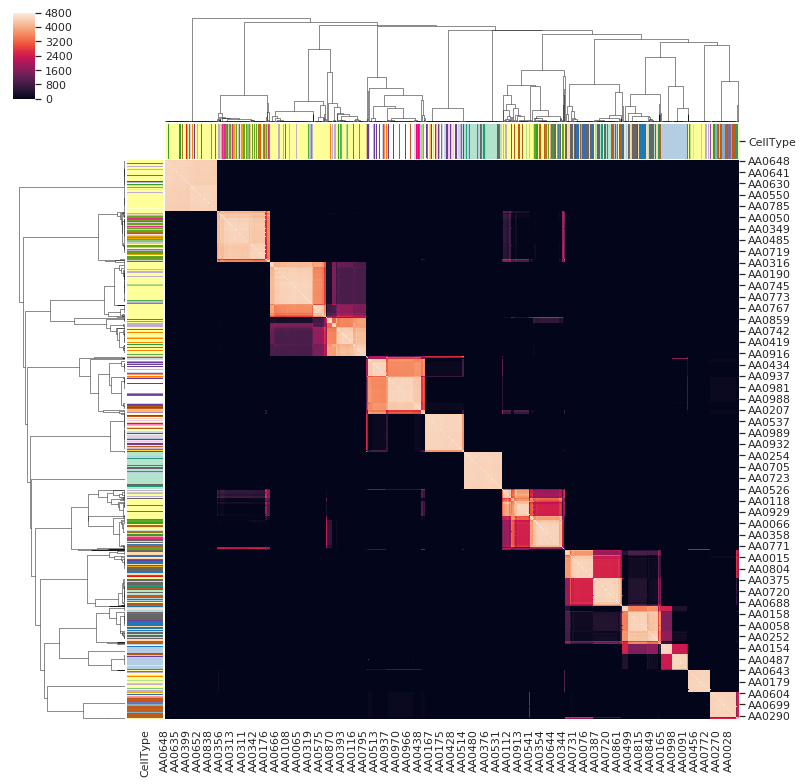

In [6]:
bestCOCLUSTER(AP_kmeansDF)

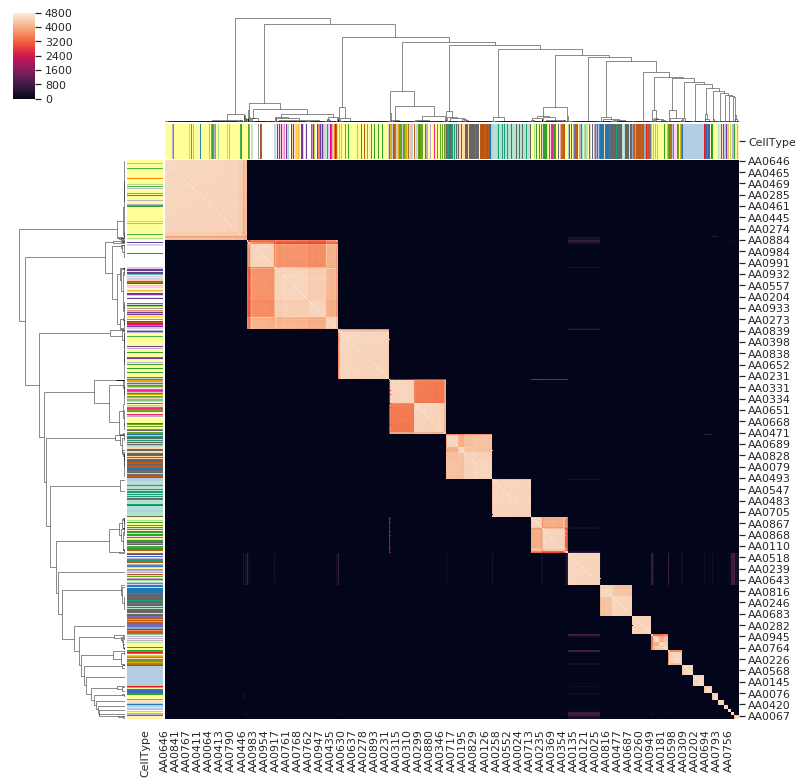

In [7]:

bestCOCLUSTER(AP_dbscanDF)

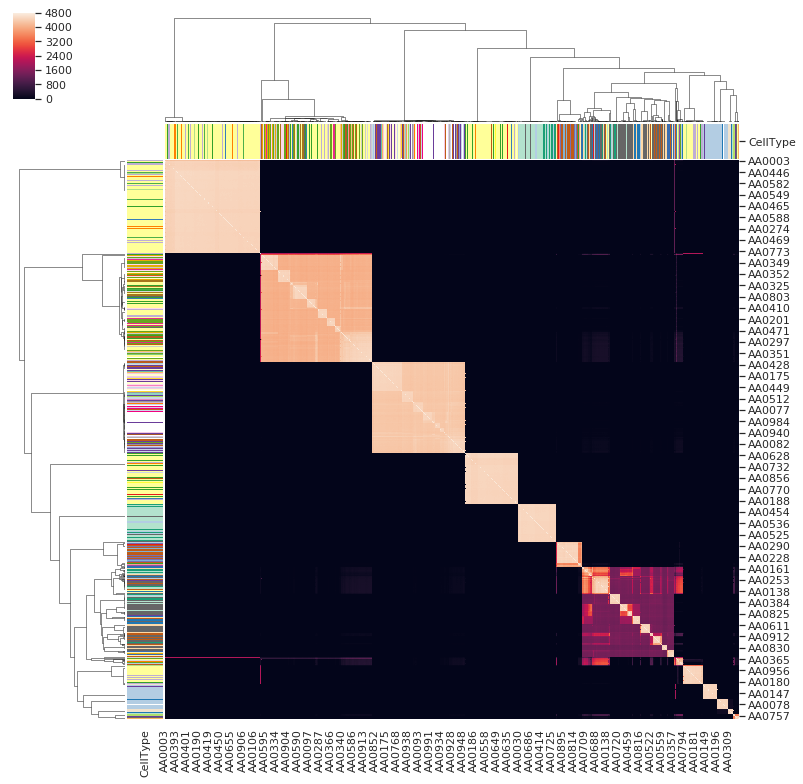

In [8]:

bestCOCLUSTER(AP_hdbscanDF)

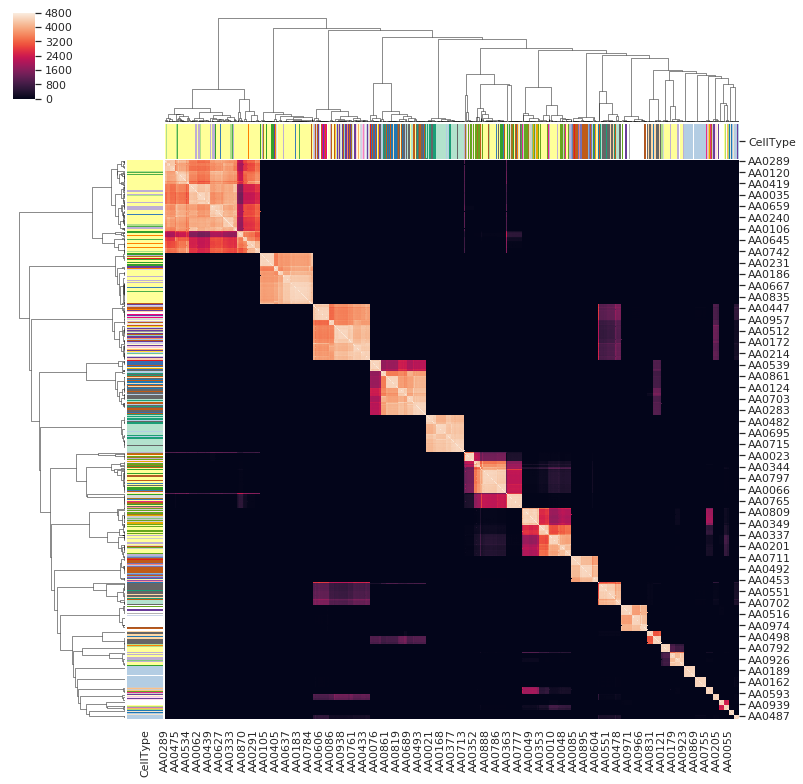

In [9]:

bestCOCLUSTER(AP_snnDF)

# Cocluster for soma location 

In [10]:
SL_hierDF = pd.read_excel('/home/penglab/FeaCal/dataSource/somaLoc/SL_hierDF.xlsx', index_col=0)
SL_kmeansDF = pd.read_excel('/home/penglab/FeaCal/dataSource/somaLoc/SL_kmeansDF.xlsx', index_col=0)
SL_dbscanDF = pd.read_excel('/home/penglab/FeaCal/dataSource/somaLoc/SL_dbscanDF.xlsx', index_col=0)
SL_hdbscanDF = pd.read_excel('/home/penglab/FeaCal/dataSource/somaLoc/SL_hdbscanDF.xlsx', index_col=0)
SL_snnDF = pd.read_excel('/home/penglab/FeaCal/dataSource/somaLoc/SL_snnDF.xlsx', index_col=0)

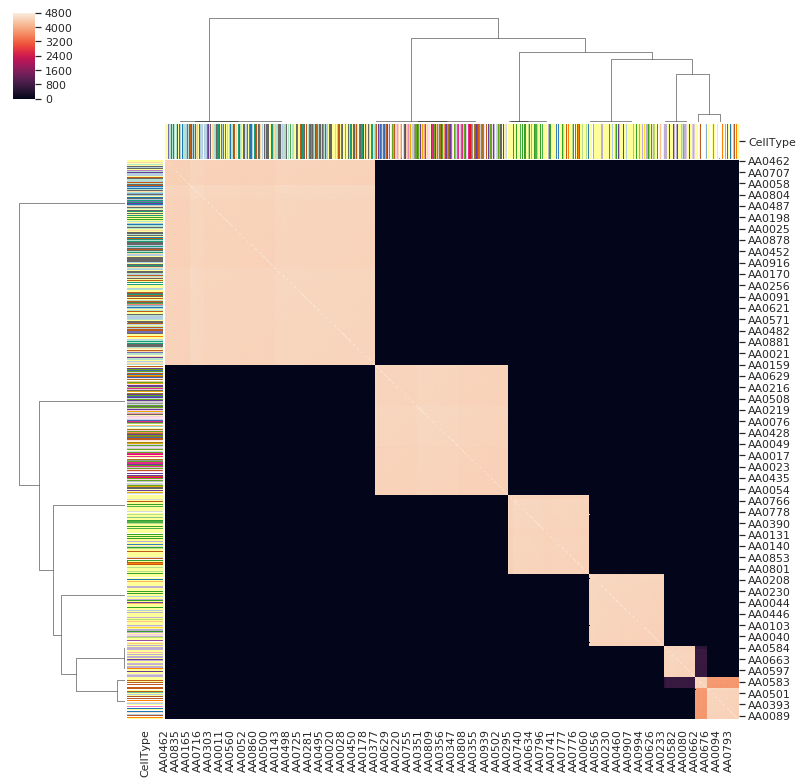

In [11]:

bestCOCLUSTER(SL_hierDF)

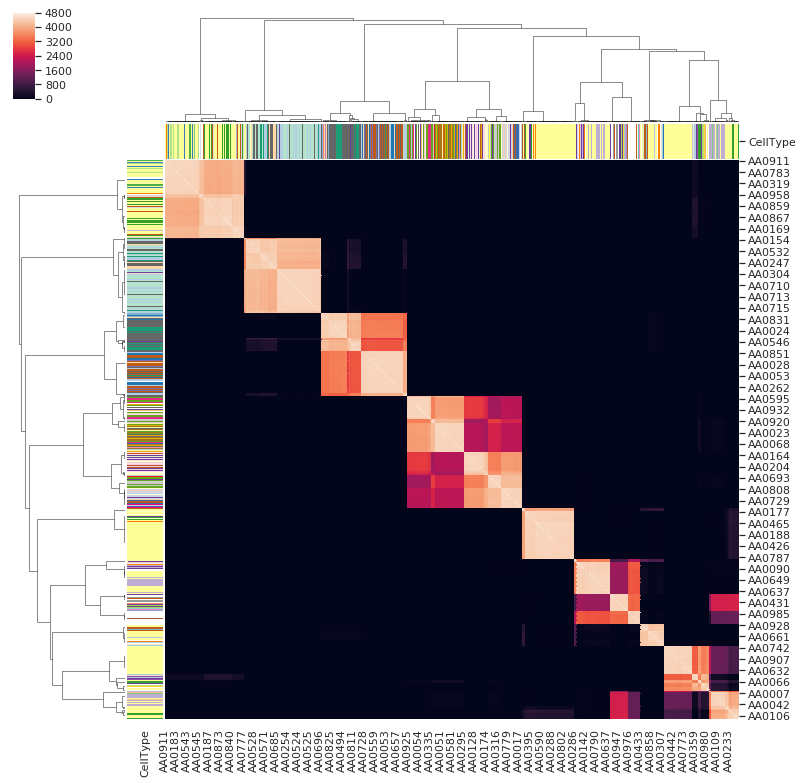

In [12]:

bestCOCLUSTER(SL_kmeansDF)

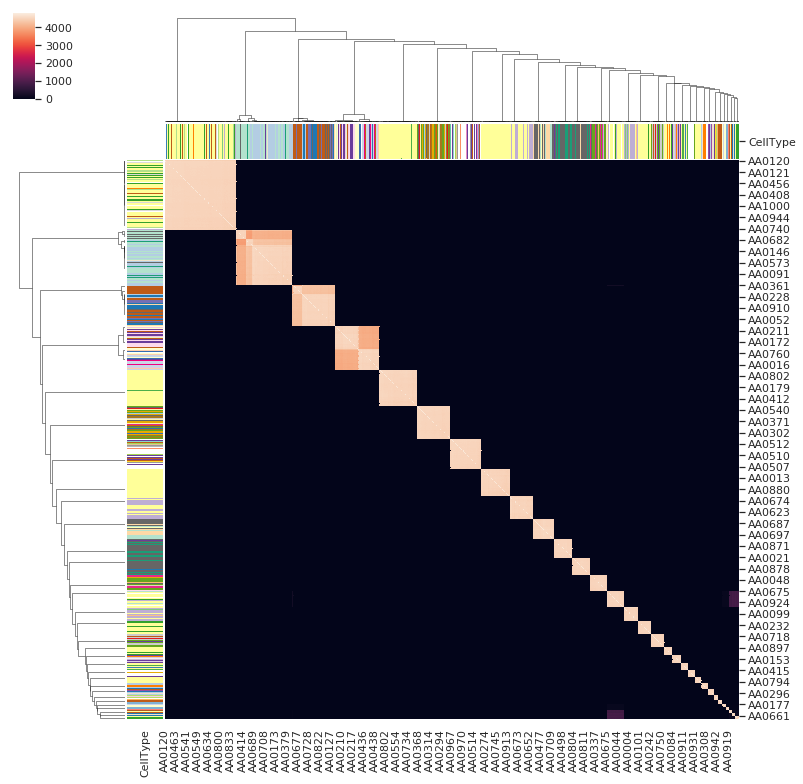

In [13]:

bestCOCLUSTER(SL_dbscanDF)

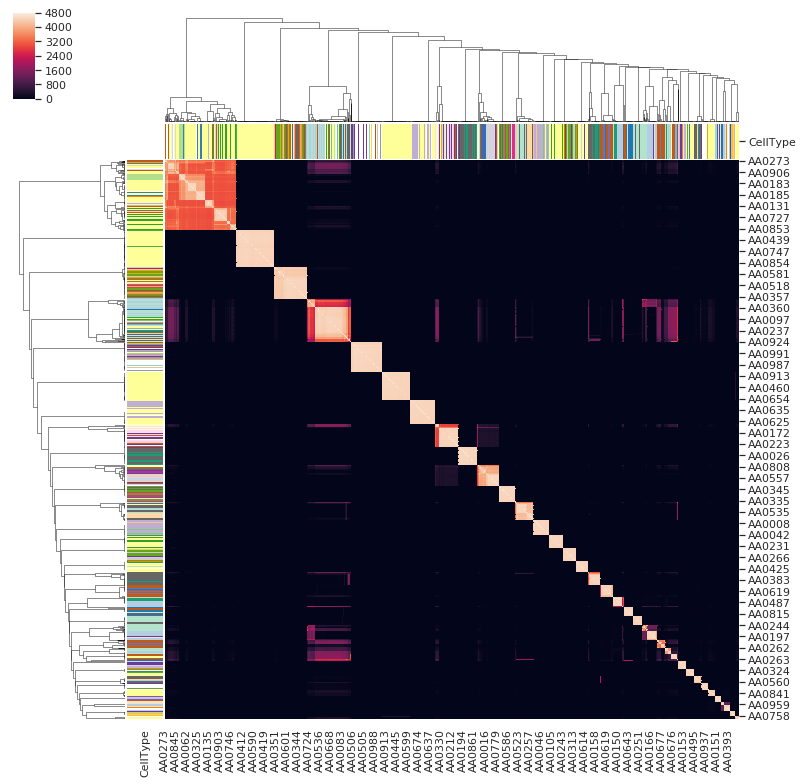

In [14]:

bestCOCLUSTER(SL_hdbscanDF)

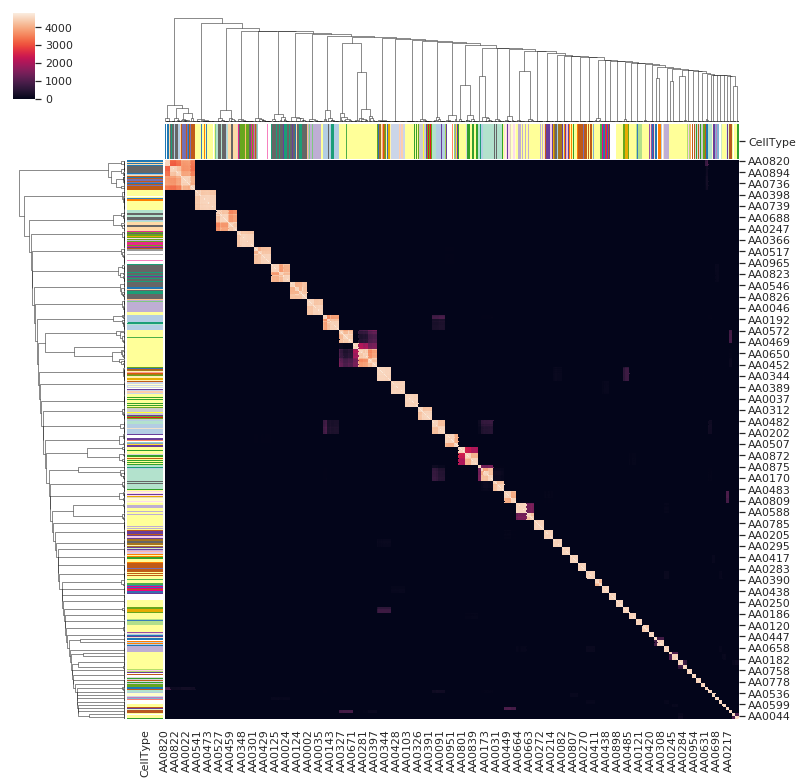

In [15]:

bestCOCLUSTER(SL_snnDF)

# Cocluster for axon morphology

# Cocluster for dendrite morphology

# Summary of clustering property

In [16]:

cluster_type = ['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN']
colname = ['ARI_'+i for i in cluster_type]
colname = colname + (['num of cluster_'+i for i in cluster_type])
summary_cluster = pd.DataFrame(index = ['axon projection','soma location', 'axon morphology', 
                                        'dendrite morphology'],columns = colname)


In [17]:
summary_cluster.loc['axon projection',:]= [0.258210445492697,0.2129613044735105,0.2812503177620878,
                                               0.28287214992477994,0.22710873358441527,19,14, 24, 31, 31]
summary_cluster.loc['soma location',:]= [0.3268728951610669, 0.27863577689094327, 0.2630886481583674,
                                         0.26100195542904575,0.13064660013981225,9,10,29,34,65]
summary_cluster.loc['axon morphology',:] = [0.08785414289406115, 0.08343509698163794, 0.10187925011450155,
                                            0.05177167199451809,0.06673692576743263,8,8,8,39,23]
summary_cluster.loc['dendrite morphology',:]= [0.05355799672049869, 0.036079814213255956, 
                                               0.039530673163787826, 0.020481889417205506, 0.045224072138369056,
                                               8,13,20,21,18]
summary_cluster

,ARI_Hierarchy,ARI_Kmeans,ARI_DBSCAN,ARI_HDBSCAN,ARI_SNN,num of cluster_Hierarchy,num of cluster_Kmeans,num of cluster_DBSCAN,num of cluster_HDBSCAN,num of cluster_SNN
axon projection,0.25821,0.212961,0.28125,0.282872,0.227109,19,14,24,31,31
soma location,0.326873,0.278636,0.263089,0.261002,0.130647,9,10,29,34,65
axon morphology,0.0878541,0.0834351,0.101879,0.0517717,0.0667369,8,8,8,39,23
dendrite morphology,0.053558,0.0360798,0.0395307,0.0204819,0.0452241,8,13,20,21,18


# Extract cluster from co-cluster matrix

NameError: name 'fcluster' is not defined

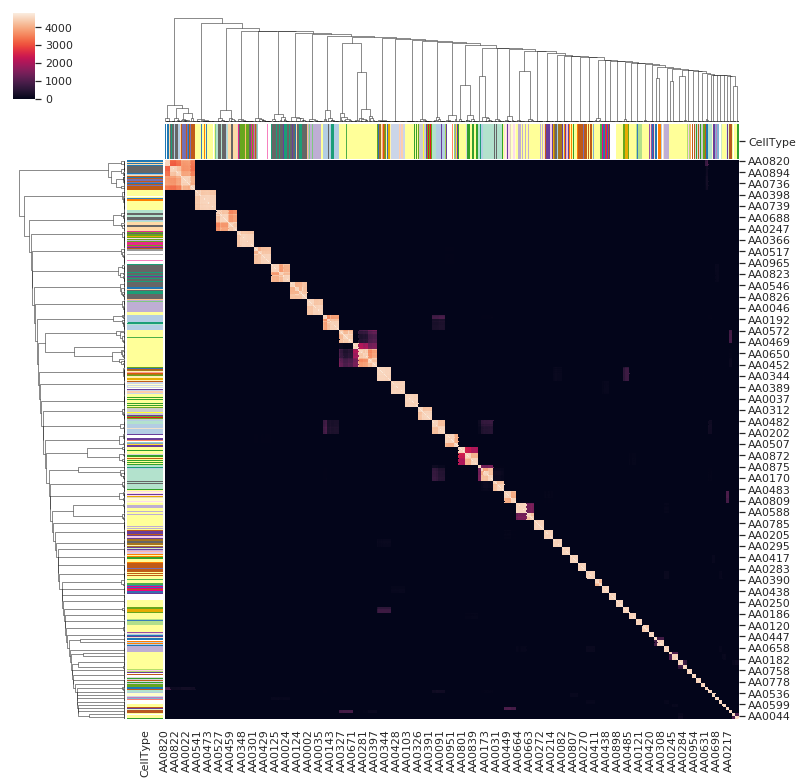

In [27]:
    df = SL_snnDF.copy()
    linkmethod = ['single', 'complete','average','weighted','centroid','median','ward']
    paraDF = pd.DataFrame(columns =['method','CCC'],index = linkmethod)
    paraDF.loc[:,'method'] = linkmethod
    
    correlations = df.corr()
    correlations_array = np.asarray(df.corr())
    for iter_m in linkmethod:
        Y = distance.pdist(np.asarray(df))
        Z = hierarchy.linkage(Y, method = iter_m)
        c, coph_dists = hierarchy.cophenet(Z,Y)
        paraDF.loc[iter_m,'CCC'] = c
    paraDF.sort_values(by='CCC', ascending = False, inplace = True)
    #print(paraDF)
    row_linkage = hierarchy.linkage(distance.pdist(np.asarray(df)), method = paraDF.iloc[0,0])

    col_linkage = hierarchy.linkage(distance.pdist(np.asarray(df).T), method = paraDF.iloc[0,0])
    #print(paraDF.iloc[0,0])
    sns.clustermap(df, row_linkage = row_linkage, col_linkage = col_linkage, row_colors=row_colors ,col_colors = row_colors, figsize=(13, 13))#, cmap=sns.diverging_palette(h_neg=150, h_pos=275, s=80, l=55, as_cmap=True))    


### Check difference between pdist, linkage and ward

distance.pdist(np.asarray(df)) == hierarchy.linkage(df)

## Test fcluster

Please input the number of cluster15


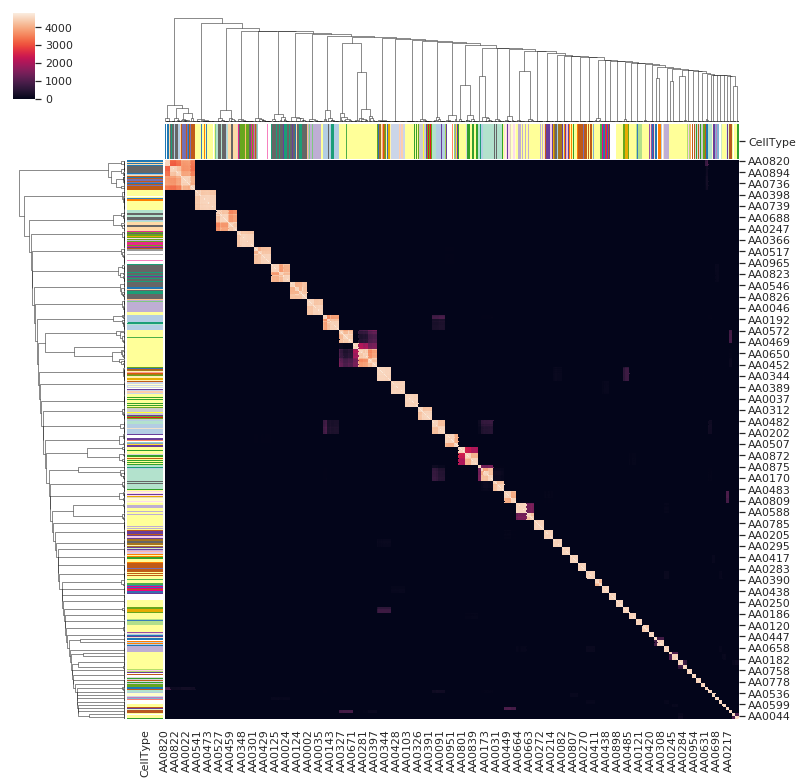

In [59]:
coclusterResult(df)

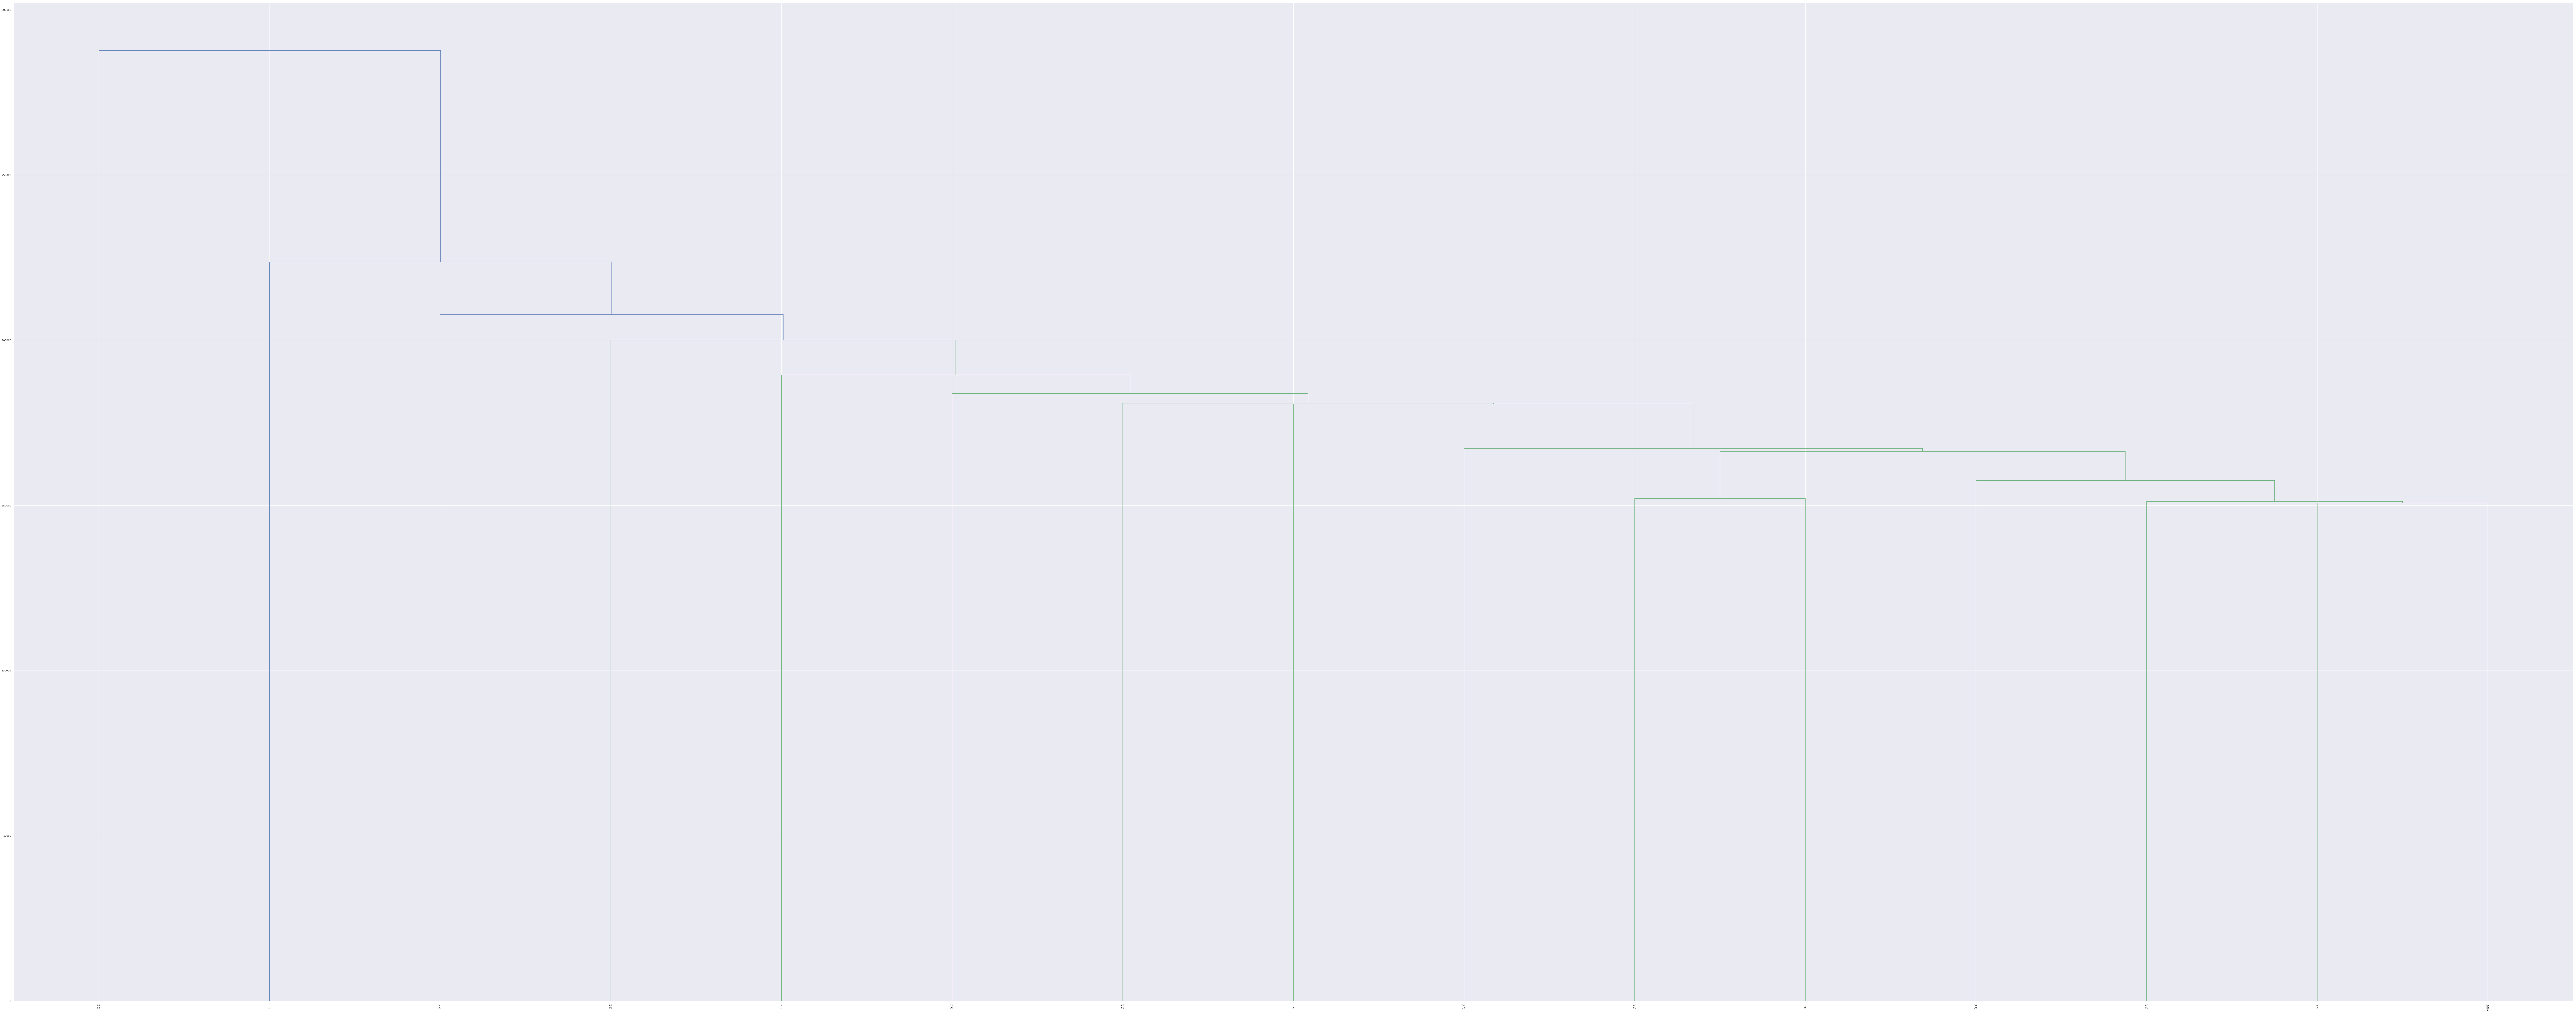

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster,inconsistent
fig, ax = plt.subplots(1, 1, figsize=(200, 80))
d = dendrogram(Z, labels=df.index, leaf_rotation=90,
               truncate_mode='lastp',  # show only the last p merged clusters
               p=15,  # show only the last p merged clusters
               orientation="top", color_threshold=None,
                   )

In [47]:
d['leaves']

[1910,
 1888,
 1907,
 1955,
 1904,
 1895,
 1897,
 1884,
 1889,
 1906,
 1953,
 1925,
 1827,
 1819,
 1958]

In [25]:
aaa.dendrogram_col.reordered_ind

[808,
 51,
 614,
 933,
 718,
 898,
 806,
 807,
 721,
 897,
 491,
 489,
 52,
 556,
 836,
 492,
 558,
 487,
 809,
 810,
 882,
 358,
 560,
 817,
 357,
 359,
 857,
 878,
 565,
 56,
 57,
 124,
 884,
 488,
 845,
 26,
 631,
 612,
 21,
 27,
 726,
 839,
 794,
 224,
 852,
 157,
 563,
 570,
 555,
 24,
 802,
 225,
 559,
 398,
 460,
 405,
 461,
 537,
 61,
 541,
 395,
 633,
 738,
 917,
 985,
 11,
 545,
 769,
 322,
 454,
 180,
 453,
 400,
 722,
 407,
 772,
 469,
 771,
 539,
 114,
 729,
 546,
 544,
 401,
 984,
 549,
 182,
 137,
 932,
 255,
 246,
 474,
 699,
 528,
 475,
 523,
 531,
 677,
 156,
 455,
 678,
 473,
 519,
 472,
 527,
 372,
 384,
 524,
 371,
 534,
 196,
 696,
 675,
 254,
 456,
 711,
 245,
 694,
 673,
 692,
 244,
 687,
 606,
 249,
 604,
 198,
 49,
 46,
 47,
 53,
 586,
 588,
 448,
 345,
 643,
 336,
 584,
 580,
 665,
 73,
 363,
 574,
 591,
 909,
 347,
 332,
 350,
 369,
 54,
 334,
 343,
 342,
 298,
 361,
 509,
 910,
 505,
 511,
 935,
 431,
 513,
 975,
 958,
 974,
 959,
 977,
 512,
 953,
 956,
 9

In [26]:
row_linkage 

array([[4.39000000e+02, 7.60000000e+02, 2.93852004e+02, 2.00000000e+00],
       [2.81000000e+02, 2.88000000e+02, 2.96334271e+02, 2.00000000e+00],
       [3.03000000e+02, 3.04000000e+02, 2.98876229e+02, 2.00000000e+00],
       ...,
       [1.90600000e+03, 1.96900000e+03, 3.14163038e+04, 8.98000000e+02],
       [1.87000000e+03, 1.97000000e+03, 3.30348223e+04, 9.34000000e+02],
       [1.91000000e+03, 1.97100000e+03, 3.48412472e+04, 9.87000000e+02]])